In [2]:
import os
import numpy as np
import pandas as pd
from surprise import Reader, Dataset, KNNBasic, KNNWithMeans, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
import random

seed = 10
random.seed(seed)
np.random.seed(seed)

In [3]:
pd.options.display.float_format = '{:.2f}'.format

In [4]:
df_genome_score = pd.read_csv(r"C:\Users\suare\Taller-1-Notebooks\genome_scores.csv")
df_genome_tags = pd.read_csv(r"C:\Users\suare\Taller-1-Notebooks\genome_tags.csv")
df_tag = pd.read_csv(r"C:\Users\suare\Taller-1-Notebooks\tag.csv")
df_movie = pd.read_csv(r"C:\Users\suare\Taller-1-Notebooks\movie.csv")
df_rating = pd.read_csv(r"C:\Users\suare\Taller-1-Notebooks\rating.csv")

In [5]:
df = df_rating.merge(df_movie, how="inner", on="movieId")[["userId","movieId","title","genres","rating","timestamp"]]

## Conocimiento del dataset de trabajo

In [6]:
df.shape

(20000263, 6)

In [7]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   title      str    
 3   genres     str    
 4   rating     float64
 5   timestamp  str    
dtypes: float64(1), int64(2), str(3)
memory usage: 915.5 MB


In [8]:
df.describe()

,userId,movieId,rating
count,20000263.00,20000263.00,20000263.00
mean,69045.87,9041.57,3.53
std,40038.63,19789.48,1.05
min,1.00,1.00,0.50
25%,34395.00,902.00,3.00
50%,69141.00,2167.00,3.50
75%,103637.00,4770.00,4.00
max,138493.00,131262.00,5.00


In [9]:
df.isnull().sum()

userId       0
movieId      0
title        0
genres       0
rating       0
timestamp    0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df["userId"].value_counts().sort_index(ascending=True)

userId
1         175
2          61
3         187
4          28
5          66
         ... 
138489     38
138490    151
138491     22
138492     82
138493    373
Name: count, Length: 138493, dtype: int64

In [12]:
df.dtypes

userId         int64
movieId        int64
title            str
genres           str
rating       float64
timestamp        str
dtype: object

In [13]:
df["title"].value_counts()

title
Pulp Fiction (1994)                                            67310
Forrest Gump (1994)                                            66172
Shawshank Redemption, The (1994)                               63366
Silence of the Lambs, The (1991)                               63299
Jurassic Park (1993)                                           59715
                                                               ...  
The Gentleman from Epsom (1962)                                    1
The Great Spy Chase (1964)                                         1
Taxi for Tobruk (1961)                                             1
Judge and the Assassin, The (Juge et l'assassin, Le) (1976)        1
Série noire (1979)                                                 1
Name: count, Length: 26729, dtype: int64

In [14]:
df["genres"].value_counts()

genres
Drama                                               1467402
Comedy                                              1316161
Comedy|Romance                                       793252
Comedy|Drama                                         656474
Drama|Romance                                        644626
                                                     ...   
Children|Drama|Thriller                                   1
Action|Adventure|Crime|Drama|Sci-Fi|Thriller|War          1
Action|Comedy|Crime|Fantasy|Thriller                      1
Adventure|Children|Comedy|Documentary|Drama               1
Action|Adventure|Comedy|Fantasy|Sci-Fi                    1
Name: count, Length: 1329, dtype: int64

In [15]:
df["rating"].skew()

-0.6553111860940569

<Axes: title={'center': 'Distribución de Calificaciones'}, ylabel='Frequency'>

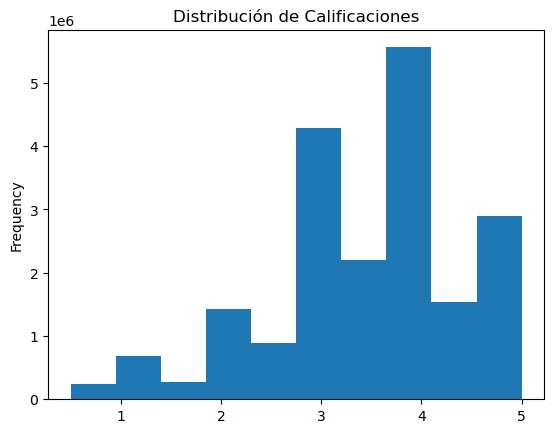

In [16]:
df["rating"].plot(kind="hist", bins=10, title="Distribución de Calificaciones")

<Axes: title={'center': 'Caja y Bigotes de Ratings'}>

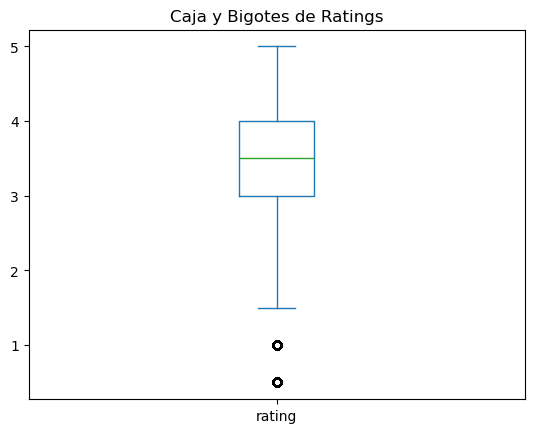

In [17]:
df["rating"].plot(kind="box", title="Caja y Bigotes de Ratings")

In [18]:
analisis_generos = df.groupby('genres')['rating'].agg(['mean', 'count'])
print(analisis_generos.sort_values(ascending=False, by='mean').head(10))

                                             mean  count
genres                                                  
Adventure|Drama|Fantasy|Musical              5.00      1
Adventure|Children|Mystery                   5.00      1
Adventure|Children|Comedy|Documentary|Drama  5.00      1
Comedy|Drama|Horror|Romance                  4.50      1
Drama|Film-Noir|Mystery|Romance|Sci-Fi       4.50      1
Crime|Fantasy|Film-Noir|Thriller             4.50      3
Action|Comedy|Crime|Fantasy|Thriller         4.50      1
Comedy|Crime|Film-Noir                       4.50      1
Children|Drama|Thriller                      4.50      1
Documentary|Drama|Mystery                    4.33      3


In [19]:
generos_confiables = analisis_generos[analisis_generos['count'] > 50000]
print(generos_confiables.sort_values(by='mean', ascending=False).head(10))

                             mean   count
genres                                   
Comedy|Crime|Drama|Thriller  4.10  123353
Comedy|Drama|Romance|War     4.06   84809
Crime|Mystery|Thriller       4.05  103738
Crime|Drama                  4.00  467417
Crime|Horror|Thriller        3.99   73784
Drama|War                    3.98  239542
Mystery|Thriller             3.97  124167
Adventure|Fantasy            3.91  105834
Action|Drama|War             3.90  213007
Drama|Mystery                3.87   71661


In [20]:
df.groupby("title")["userId"].count().sort_values(ascending=False)

title
Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
                                    ...  
The Hatchet Man (1932)                  1
The Harry Hill Movie (2013)             1
The Harmony Game (2011)                 1
The Hanoi Hilton (1987)                 1
貞子3D (2012)                             1
Name: userId, Length: 26729, dtype: int64

## Pre-procesamiento de datos

In [21]:
# El analisis muestra un valor alto de peliculas que han sido calificadas muy pocas veces.
counts = df.groupby("title")["rating"].agg(['count', 'mean'])
umbral = counts.quantile(0.25)['count']
titulos_keep = counts[(counts['count'] >= umbral) | (counts['mean'] <= 2.0)].index
df_final = df[df["title"].isin(titulos_keep)]

In [22]:
df_final["rating"].skew()

-0.6554729054338951

In [23]:
df_final.dtypes

userId         int64
movieId        int64
title            str
genres           str
rating       float64
timestamp        str
dtype: object

In [30]:
df_sample = df_final.sample(frac=0.1, random_state=42)

In [31]:
reader = Reader(rating_scale = (0.5, 5.0))
surprise_dataset = Dataset.load_from_df(df_sample[['userId', 'movieId', 'rating']], reader)

In [32]:
surprise_dataset.df.head()

,userId,movieId,rating
17603918,121756,368,4.00
2100359,14215,480,4.00
10404387,71973,47,4.00
9530191,65959,1674,4.00
9673657,66898,2657,3.00


In [34]:
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)

In [35]:
train_set.n_ratings

1599495

In [36]:
len(test_set)

399874

## Construcción de modelos colaborativos usuario-usuario

In [ ]:
df_final.groupby('userId').count()['rating']

userId
1         175
2          61
3         187
4          28
5          66
         ... 
138489     38
138490    151
138491     22
138492     82
138493    373
Name: rating, Length: 138493, dtype: int64

: 

In [ ]:
user_counts = df_final.groupby('userId').count()['rating']

usuarios_expertos = user_counts[user_counts > 400].index 

df_ultra_filtrado = df_final[df_final['userId'].isin(usuarios_expertos)]

print(f"Usuarios únicos finales: {df_ultra_filtrado['userId'].nunique()}")

Usuarios únicos finales: 10634


In [44]:
reader = Reader(rating_scale = (0.5, 5.0))
surprise_dataset = Dataset.load_from_df(df_ultra_filtrado[['userId', 'movieId', 'rating']], reader)

In [45]:
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)

In [50]:
sim_options = {'name': 'pearson_baseline',
               'user_based': True,  # calcule similitud usuario-usuario
               'min_support': 5
               }
algo = KNNWithMeans(k=40, min_k=20, sim_options=sim_options)

algo.fit(trainset=train_set)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [51]:
test_predictions = algo.test(test_set)

In [52]:
accuracy.rmse(test_predictions, verbose = True )

RMSE: 0.7722


0.7722304899354108

In [47]:
#param_grid = {
#    'k': [20, 40, 60],
#    'min_k': [3,5],
#    'sim_options':{
#        'name': 'pearson_baseline',
#        'user_based': [True],
#        'shrinkage': [0, 100]
#    }
#}
#gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=2, n_jobs=-1)

In [ ]:
#gs.fit(surprise_dataset)

In [ ]:
#print(gs.best_score['rmse'])
#print(gs.best_params['rmse'])